# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.shape

(891221, 85)

**There are 891,221 rows and 85 columns in the azdias dataframe.**

In [4]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

**Now let's take a look at the feat_info dataframe.**

In [6]:
feat_info.shape

(85, 4)

In [7]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [8]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


**There are significantly less columns and rows in the feat_info dataframe. 85 rows and 4 columns.**

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**Before we convert missing and unknown values in the dataframe, let's see how many missing values there are currently.**

In [9]:
# show number of missing values

azdias.isna().sum().sum()

4896838

In [10]:
azdias.sum().sum()

3281221885.0

In [11]:
(4896838 / 3281221885.0) * 100

0.14923824634919503

**Ok, we can see there are 4,896,838 missing values in a dataframe that has a total of 3,281,221,885 values. Which gives us roughly 15% of our data that is labeled NaN.**

In [12]:
# Identify missing or unknown data values and convert them to NaNs.

for i in range(len(feat_info)):
    mou = feat_info.iloc[i]['missing_or_unknown']
    mou = mou.strip('[' + ']')
    mou = mou.split(sep=',')
    mou = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in mou]
    if mou != ['']:
        azdias = azdias.replace({feat_info.iloc[i]['attribute']: mou}, np.nan)


**Now that we've parsed through our data for missing or unknown values let's see how many there actually are after we've converted them to NaN.**

In [13]:
# show number of missing values

azdias.isna().sum().sum()

8373929

In [14]:
(8373929 / 3281221885.0) * 100

0.2552076419543935

**So in reality there was roughly 10% more missing data then we orginally thought. The total amount of NaN values in our dataset is 8,373,929.**

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [15]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

percent_missing = (azdias.isnull().sum()/ len(azdias)) * 100
percent_missing

AGER_TYP                 76.955435
ALTERSKATEGORIE_GROB      0.323264
ANREDE_KZ                 0.000000
CJT_GESAMTTYP             0.544646
FINANZ_MINIMALIST         0.000000
FINANZ_SPARER             0.000000
FINANZ_VORSORGER          0.000000
FINANZ_ANLEGER            0.000000
FINANZ_UNAUFFAELLIGER     0.000000
FINANZ_HAUSBAUER          0.000000
FINANZTYP                 0.000000
GEBURTSJAHR              44.020282
GFK_URLAUBERTYP           0.544646
GREEN_AVANTGARDE          0.000000
HEALTH_TYP               12.476816
LP_LEBENSPHASE_FEIN      10.954859
LP_LEBENSPHASE_GROB      10.611509
LP_FAMILIE_FEIN           8.728699
LP_FAMILIE_GROB           8.728699
LP_STATUS_FEIN            0.544646
LP_STATUS_GROB            0.544646
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
RETOURTYP_BK_S            0.544646
SEMIO_SOZ                 0.000000
SEMIO_FAM                 0.000000
SEMIO_REL                 0.000000
SEMIO_MAT                 0.000000
SEMIO_VERT          

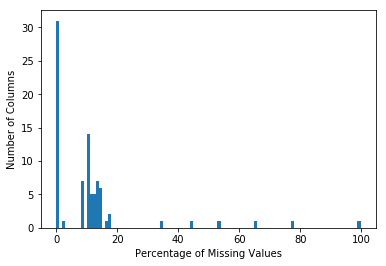

In [16]:
# Investigate patterns in the amount of missing data in each column.

plt.hist(percent_missing, bins=100)
plt.ylabel('Number of Columns')
plt.xlabel('Percentage of Missing Values')
plt.show()

In [17]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)


# first we add the columns with more than 20% missing data
columns_to_drop = percent_missing[percent_missing > 20]

#then we drop those columns in the azdias dataframe
columns_to_drop

AGER_TYP        76.955435
GEBURTSJAHR     44.020282
TITEL_KZ        99.757636
ALTER_HH        34.813699
KK_KUNDENTYP    65.596749
KBA05_BAUMAX    53.468668
dtype: float64

In [18]:
# then we set up our variable in way we can drop the columns 

columns_to_drop_list = columns_to_drop.index.tolist()

columns_to_drop_list

['AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX']

In [19]:
# drop the columns & update our dataframe

azdias = azdias.drop(columns_to_drop_list, axis=1)

In [20]:
# view the updated dataframe

azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

**If we take a look at the preview shown of percent_missing there are a few columns that stand out as having a significant amount of data missing. Although insights can still be gathered with large amounts of missing data as shown <a href="https://www.sciencedirect.com/science/article/pii/S0895435618308710">here</a>, the majority of our columns don't have more than 20% of the data missing therefore it's an appropriate number to choose from. If our dataset had more than 20% missing data in its column, we dropped it. AGER_TYP, KBA05_BAUMAX, and GEBURTSJAHR had some of the largest amounts of missing data.**

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

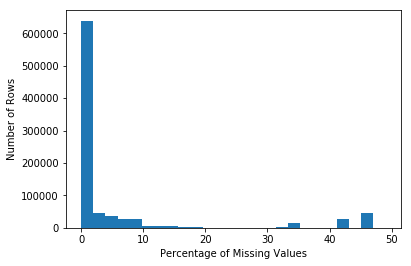

In [21]:
# How much data is missing in each row of the dataset?
missing_rows = azdias.isnull().sum(axis=1)

missing = []
for rows in range(0, len(missing_rows)):
    missing.append(missing_rows[rows])

plt.hist(missing, bins=25)
plt.ylabel('Number of Rows')
plt.xlabel('Percentage of Missing Values')
plt.show()

In [22]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
data_subset_one =  azdias[azdias.isnull().sum(axis=1) <= 15]
data_subset_two = azdias[azdias.isnull().sum(axis=1) > 15]

In [23]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

min_missing_columns = ['ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER' ]

updated_subset_one = data_subset_one[min_missing_columns]
updated_subset_two = data_subset_two[min_missing_columns]


In [24]:
len(min_missing_columns)

5

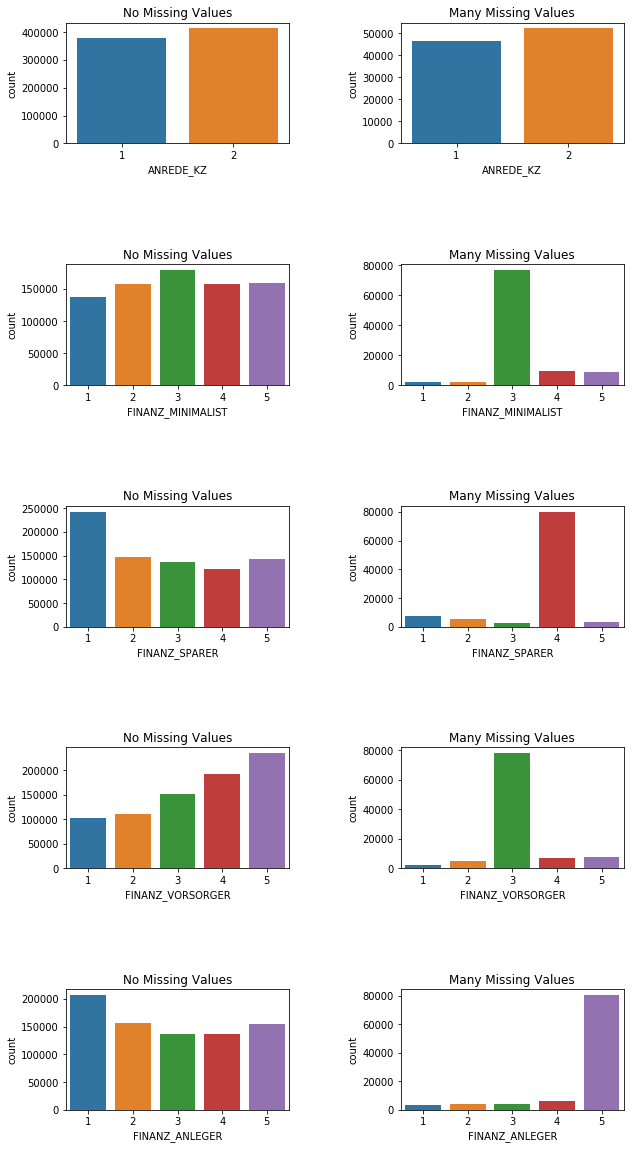

In [52]:
charts, labels = plt.subplots(nrows=len(min_missing_columns), ncols=2, figsize = (10,20))
charts.subplots_adjust(hspace = 1, wspace=.5)

for i in range(len(min_missing_columns)):
    sns.countplot(updated_subset_one[min_missing_columns[i]], ax=labels[i][0])
    labels[i][0].set_title('No Missing Values')
    sns.countplot(updated_subset_two[min_missing_columns[i]], ax=labels[i][1])
    labels[i][1].set_title('Many Missing Values')

#### Discussion 1.1.3: Assess Missing Data in Each Row

**Based on the two subsets of data it's clear that removing missing data has an effect on our results. The charts on the left side are more evenly distributed but the charts on the right mostly have one clear area that's larger. However, the first two charts are similar.**

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [53]:
drop_feat = []
for i in range(0, feat_info.shape[0]):
    if feat_info['attribute'][i] in columns_to_drop_list:
        drop_feat.append(i)
print(drop_feat)


[0, 11, 40, 43, 47, 64]


In [220]:
feat_info_updated = feat_info.drop(drop_feat, axis=0)
feat_info_updated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79 entries, 1 to 84
Data columns (total 4 columns):
attribute             79 non-null object
information_level     79 non-null object
type                  79 non-null object
missing_or_unknown    79 non-null object
dtypes: object(4)
memory usage: 3.1+ KB


In [221]:
# How many features are there of each data type?
feat_info_updated.groupby(['type']).count()

,attribute,information_level,missing_or_unknown
type,,,
categorical,18,18,18
mixed,6,6,6
numeric,6,6,6
ordinal,49,49,49


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [222]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

feat_categorical = feat_info_updated[feat_info_updated['type'] == 'categorical']['attribute']

In [205]:
feat_categorical

2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
41            VERS_TYP
42            ZABEOTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object

In [59]:
# list of binary and multilevel features

binary_feat = []
multi_feat = []

for i in feat_categorical:
    if (len(data_subset_one[i].unique())==2):
        binary_feat.append(i)
    elif (len(data_subset_one[i].unique())>2):
        multi_feat.append(i)

In [60]:
binary_feat

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'OST_WEST_KZ']

In [61]:
multi_feat

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [62]:
# Re-encode categorical variable(s) to be kept in the analysis.
for i in binary_feat:
     print(i,data_subset_one[i].unique())

ANREDE_KZ [2 1]
GREEN_AVANTGARDE [0 1]
SOHO_KZ [ 1.  0.]
OST_WEST_KZ ['W' 'O']


In [63]:
ost_values = {'W': 0, 'O': 1}
azdias_updated = data_subset_one.replace({'OST_WEST_KZ':ost_values})

In [64]:
azdias_updated['OST_WEST_KZ'].nunique()

2

In [65]:
azdias_updated['OST_WEST_KZ'].head(5)

1    0
2    0
3    0
4    0
5    0
Name: OST_WEST_KZ, dtype: int64

In [66]:
# drop multilevel features
for i in multi_feat:
    azdias_updated=azdias_updated.drop(i, axis=1)

In [67]:
azdias_updated.head(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2,1,5,2,5,4,5,0,3.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


#### Discussion 1.2.1: Re-Encode Categorical Features

**After getting all the categorical features, I seperated them into two seperate lists binary and multilevel. After doing that, I noticed that OST_WEST_KZ wasn't in integers but two seperate characters W and O. I converted these values into 0 and 1 respectively. Once this was done, to ensure a simpler analysis process I dropped all of the multi-level features and kept the binary features.**

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

### PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [68]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# column for decade portion
azdias_updated['PRAEGENDE_JUGENDJAHRE_DECADE'] = azdias_updated['PRAEGENDE_JUGENDJAHRE']

# column for movement portion
azdias_updated['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = azdias_updated['PRAEGENDE_JUGENDJAHRE']

In [69]:
# create dictionaries of values for each column


# an interval-type variable for decade

decade = {1:'40s',2:'40s',3:'50s',4:'50s',5:'60s',
          6:'60s',7:'60s',8:'70s',9:'70s',10:'80s',
          11:'80s',12:'80s',13:'80s', 14:'90s',15:'90s'}


# a binary variable for movement

movement = {1:0,2:1, 3:1,4:0,5:0,
            6:1, 7:1,8:0,9:1, 10:0,
            11:1,12:0,13:1,14:0,15:1 }

azdias_updated['PRAEGENDE_JUGENDJAHRE_DECADE'].replace(decade, inplace=True)
azdias_updated['PRAEGENDE_JUGENDJAHRE_MOVEMENT'].replace(movement, inplace=True)

In [70]:
azdias_updated['PRAEGENDE_JUGENDJAHRE_DECADE'].head()

1    90s
2    90s
3    70s
4    70s
5    50s
Name: PRAEGENDE_JUGENDJAHRE_DECADE, dtype: object

In [71]:
azdias_updated['PRAEGENDE_JUGENDJAHRE_MOVEMENT'].head()

1    0.0
2    1.0
3    0.0
4    0.0
5    1.0
Name: PRAEGENDE_JUGENDJAHRE_MOVEMENT, dtype: float64

### CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown


In [72]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
# column for household portion
azdias_updated['CAMEO_INTL_2015_HOUSEHOLD'] = azdias_updated['CAMEO_INTL_2015']

# column for lifestage portion
azdias_updated['CAMEO_INTL_2015_LIFESTAGE'] = azdias_updated['CAMEO_INTL_2015']

In [73]:
# create dictionaries of values for each column

# household 
household = {11:1, 12:1, 13:1, 14:1, 15:1, 
             21:2, 22:2, 23:2, 24:2, 25:2, 
             31:3, 32:3, 33:3, 34:3, 35:3, 
             41:4, 42:4, 43:4, 44:4, 45:4,
             51:5, 52:5, 53:5, 54:5, 55:5}

# lifestage
lifestage = {11:1, 12:2, 13:3, 14:4, 15:5,
            21:1, 22:2, 23:3, 24:4, 25:5, 
            31:1, 32:2, 33:3, 34:4, 35:5,
            41:1, 42:2, 43:3, 44:4, 45:5,
            51:1, 52:2, 53:3, 54:4, 55:5}

# update dataframe

azdias_updated['CAMEO_INTL_2015_HOUSEHOLD'].replace(household, inplace=True)
azdias_updated['CAMEO_INTL_2015_LIFESTAGE'].replace(lifestage, inplace=True)

In [74]:
azdias_updated['CAMEO_INTL_2015_HOUSEHOLD'].head()

1    51
2    24
3    12
4    43
5    54
Name: CAMEO_INTL_2015_HOUSEHOLD, dtype: object

In [75]:
azdias_updated['CAMEO_INTL_2015_LIFESTAGE'].head()

1    51
2    24
3    12
4    43
5    54
Name: CAMEO_INTL_2015_LIFESTAGE, dtype: object

#### Discussion 1.2.2: Engineer Mixed-Type Features

**I kept the PRAEGENDE_JUGENDJAHRE and the CAMEO_INTL_2015 mixed features. First I looked at the Data_Dictionary.md file, then I created two columns for each section of those features that will be explored. I created two dictionaries to seperate those values and then added the values into the columns. I repeated this step for CAMEO_INTL_2015 as well. Additionally, I've decided to drop the other mixed features.**

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [76]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

mixed = feat_info_updated[feat_info_updated['type'] == 'mixed']['attribute']

for i in mixed:
    azdias_updated.drop(i,axis=1,inplace=True)

In [77]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

azdias_updated.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_HOUSEHOLD,CAMEO_INTL_2015_LIFESTAGE
1,1.0,2,1,5,2,5,4,5,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,90s,0.0,51,51
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,90s,1.0,24,24
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0.0,3.0,4.0,2.0,3.0,3.0,70s,0.0,12,12
4,3.0,1,4,3,4,1,3,2,0,3.0,...,1.0,3.0,3.0,4.0,6.0,5.0,70s,0.0,43,43
5,1.0,2,3,1,5,2,2,5,0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,50s,1.0,54,54


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [198]:
feat_info_updated

,attribute,information_level,type,missing_or_unknown
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]
10,FINANZTYP,person,categorical,[-1]


In [240]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...

    for i in range(len(feat_info)):
        mou = feat_info.iloc[i]['missing_or_unknown']
        mou = mou.strip('[' + ']')
        mou = mou.split(sep=',')
        mou = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in mou]
        if mou != ['']:
            df_clean = df.replace({feat_info.iloc[i]['attribute']: mou}, np.nan)
    
    for col in df.columns:
        df_clean = df_clean.replace({col: ['XX', 'X']}, np.nan)
    
    # list of columns with more than 20% missing data
    # these will be dropped from df_clean
    
    
    columns_to_drop = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    df_clean = df_clean.drop(columns_to_drop, axis=1)
    
    # drop rows with more than 15 missing values
    
    df_clean =  df_clean[df_clean.isnull().sum(axis=1) <= 15]
    
    # select, re-encode, and engineer column values
    encoded_values = {'W': 0, 'O': 1}
    df_clean =df_clean.replace({'OST_WEST_KZ':encoded_values})
    


    # multi-level features drop                       
    feat_categorical = feat_info_updated[feat_info_updated['type'] == 'categorical']['attribute']
    multi_feat=[]

    for i in feat_categorical:
        if (len(data_subset_one[i].unique()) > 2):
            multi_feat.append(i)
                               
    for i in multi_feat:
        df_clean = df_clean.drop(i,axis=1)
                               
    # engineer features                       
    df_clean['PRAEGENDE_JUGENDJAHRE_DECADE'] = df_clean['PRAEGENDE_JUGENDJAHRE']

    # column for movement portion
    df_clean['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = df_clean['PRAEGENDE_JUGENDJAHRE']
    
    # create dictionaries of values for each column
    # an interval-type variable for decade

    decade = {1:'40s',2:'40s',3:'50s',4:'50s',5:'60s',
              6:'60s',7:'60s',8:'70s',9:'70s',10:'80s',
              11:'80s',12:'80s',13:'80s', 14:'90s',15:'90s'}

    # a binary variable for movement

    movement = {1:0,2:1, 3:1,4:0,5:0,
                6:1, 7:1,8:0,9:1, 10:0,
                11:1,12:0,13:1,14:0,15:1 }
                               
    df_clean['PRAEGENDE_JUGENDJAHRE_DECADE'].replace(decade, inplace=True)
    df_clean['PRAEGENDE_JUGENDJAHRE_MOVEMENT'].replace(movement, inplace=True)
    
    
    # column for household portion
    df_clean['CAMEO_INTL_2015_HOUSEHOLD'] = df_clean['CAMEO_INTL_2015']

    # column for lifestage portion
    df_clean['CAMEO_INTL_2015_LIFESTAGE'] = df_clean['CAMEO_INTL_2015']
                               
    # create dictionaries of values for each column

    # household 
    household = {11:1, 12:1, 13:1, 14:1, 15:1, 
                 21:2, 22:2, 23:2, 24:2, 25:2, 
                 31:3, 32:3, 33:3, 34:3, 35:3, 
                 41:4, 42:4, 43:4, 44:4, 45:4,
                 51:5, 52:5, 53:5, 54:5, 55:5}

    # lifestage
    lifestage = {11:1, 12:2, 13:3, 14:4, 15:5,
                21:1, 22:2, 23:3, 24:4, 25:5, 
                31:1, 32:2, 33:3, 34:4, 35:5,
                41:1, 42:2, 43:3, 44:4, 45:5,
                51:1, 52:2, 53:3, 54:4, 55:5}

    # update dataframe

    df_clean['CAMEO_INTL_2015_HOUSEHOLD'].replace(household, inplace=True)
    df_clean['CAMEO_INTL_2015_LIFESTAGE'].replace(lifestage, inplace=True)
                               
    mixed = feat_info_updated[feat_info_updated['type'] == 'mixed']["attribute"]
    for i in mixed:
        df_clean.drop(i, axis=1, inplace=True)
    

    # return the clean dataframe
                               
    return df_clean
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [113]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
from sklearn.preprocessing import Imputer

replace_nan = Imputer(strategy='most_frequent')
azdias_final_imputed = pd.DataFrame(replace_nan.fit_transform(azdias_updated))

In [114]:
azdias_final_imputed.columns = azdias_updated.columns
azdias_final_imputed.index = azdias_updated.index

In [115]:
azdias_final_imputed.isna().sum().sum()

0

In [116]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler

azdias_scaler = StandardScaler()

azdias_final_scaled = azdias_scaler.fit_transform(azdias_final_imputed)

In [117]:
azdias_final = pd.DataFrame(azdias_final_scaled, columns=list(azdias_final_imputed))

In [118]:
azdias_final.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_HOUSEHOLD,CAMEO_INTL_2015_LIFESTAGE
0,-1.766833,0.958103,-1.492816,1.538634,-1.042098,1.466664,0.966060,1.335003,-0.531050,1.009006,...,0.404354,0.435807,1.448637,0.570403,-0.173897,-0.128877,0.683117,-0.595616,1.096127,1.096127
1,0.200034,0.958103,-1.492816,0.865411,-1.768435,-0.570410,0.250485,1.335003,1.883063,1.009006,...,-0.618844,-0.940896,0.414633,0.570403,-0.173897,-0.128877,-0.791142,1.678935,-0.826912,-0.826912
2,1.183468,0.958103,0.684789,-0.481036,1.136914,-0.570410,-1.180665,-0.799862,-0.531050,-0.313245,...,0.404354,-0.940896,-0.619371,0.570403,-1.176336,-0.999582,-0.054012,-0.595616,-1.681595,-1.681595
3,0.200034,-1.043729,0.684789,0.192187,0.410577,-1.249434,0.250485,-0.799862,-0.531050,1.009006,...,0.404354,0.435807,-0.619371,-0.338352,0.828542,0.306475,1.420247,-0.595616,0.526338,0.526338
4,-1.766833,0.958103,-0.041079,-1.154259,1.136914,-0.570410,-0.465090,1.335003,-0.531050,1.009006,...,-0.618844,0.435807,1.448637,1.479158,-1.176336,-0.999582,-0.054012,1.678935,1.309798,1.309798


### Discussion 2.1: Apply Feature Scaling

**When I first attempted to replace the NaN values with the most_frequent, I ran into an error because of the Decade column containing strings so I dropped that column to make it easier to work with the data. Then I replcaed the NaN values using Imputer then checked if there were any NaN values in dataframe to ensure that the process has worked as intended. After completing this step, I used the StandardScalar to scale all of the features and stored everything in the azdias_final dataframe.**

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [119]:
# Apply PCA to the data.
from sklearn.decomposition import PCA

pca_azdias = PCA()

pca_azdias.fit(azdias_final)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

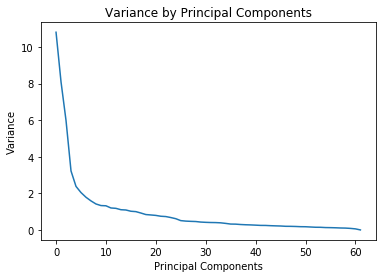

In [120]:
# Investigate the variance accounted for by each principal component.
plt.plot(range(len(pca_azdias.explained_variance_)), pca_azdias.explained_variance_);
plt.xlabel('Principal Components');
plt.ylabel('Variance');
plt.title('Variance by Principal Components');

Based on this plot it seems after around 30 components the variance levels off.

In [121]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca_azdias_30 = PCA(n_components=30)
pca_azdias_final = pca_azdias_30.fit_transform(azdias_final)
pca_azdias_final

array([[ 3.50074007, -2.60155101, -3.14092562, ...,  0.84066589,
        -0.05006767,  0.53331356],
       [-1.02747814,  0.96795514, -2.86549303, ..., -0.12469583,
        -0.02303781, -0.42825755],
       [-4.04730732,  1.78303497, -0.50943337, ..., -0.41081652,
        -0.23796488,  1.00694492],
       ..., 
       [-1.36799676, -2.77634579, -3.02887954, ..., -1.15142626,
        -1.71854209,  0.39591343],
       [ 5.40377322, -3.9627615 ,  1.99640005, ...,  0.16384474,
        -0.16296234,  0.09748217],
       [-0.53528542,  0.63038347,  3.17486436, ...,  0.87058582,
         0.64021992,  1.30795174]])

### Discussion 2.2: Perform Dimensionality Reduction

**I am retaining 30 principled components based on the plot showing a decreased variance after 30 components.**

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [89]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def map_pca(pca_azdias, i):
    data_azdias = pd.DataFrame(pca_azdias.components_,columns=list(azdias_final.columns))
    weights = data_azdias.iloc[i].sort_values(ascending=False)
    return weights

In [90]:
pca_weight_zero = map_pca(pca_azdias_30, 0)
pca_weight_zero

PLZ8_ANTG3                        0.233755
PLZ8_ANTG4                        0.224549
CAMEO_INTL_2015_LIFESTAGE         0.216695
CAMEO_INTL_2015_HOUSEHOLD         0.216695
HH_EINKOMMEN_SCORE                0.207813
ORTSGR_KLS9                       0.203824
EWDICHTE                          0.201771
FINANZ_HAUSBAUER                  0.171651
PLZ8_ANTG2                        0.160102
KBA05_ANTG4                       0.159722
ARBEIT                            0.151021
RELAT_AB                          0.141926
ANZ_HAUSHALTE_AKTIV               0.141518
KBA05_ANTG3                       0.140902
FINANZ_SPARER                     0.119502
SEMIO_PFLICHT                     0.091090
SEMIO_REL                         0.087674
SEMIO_RAT                         0.074764
SEMIO_MAT                         0.064363
SEMIO_TRADV                       0.064072
SEMIO_FAM                         0.061960
REGIOTYP                          0.060455
OST_WEST_KZ                       0.057947
SEMIO_KULT 

In [91]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_weight_one = map_pca(pca_azdias_30, 1)
pca_weight_one

ALTERSKATEGORIE_GROB              0.276587
SEMIO_ERL                         0.258822
FINANZ_VORSORGER                  0.239673
SEMIO_LUST                        0.192143
RETOURTYP_BK_S                    0.159320
SEMIO_KRIT                        0.137107
SEMIO_KAEM                        0.134091
ANREDE_KZ                         0.117266
W_KEIT_KIND_HH                    0.101889
FINANZ_HAUSBAUER                  0.097790
SEMIO_DOM                         0.092125
FINANZ_MINIMALIST                 0.083584
EWDICHTE                          0.067645
ORTSGR_KLS9                       0.066011
WOHNDAUER_2008                    0.065376
PLZ8_ANTG3                        0.063800
PLZ8_ANTG4                        0.061532
CAMEO_INTL_2015_HOUSEHOLD         0.054679
CAMEO_INTL_2015_LIFESTAGE         0.054679
KBA05_ANTG4                       0.050948
ARBEIT                            0.048880
RELAT_AB                          0.048306
PLZ8_ANTG2                        0.044921
ANZ_HAUSHAL

In [92]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_weight_two = map_pca(pca_azdias_30, 2)
pca_weight_two

SEMIO_VERT                        0.342557
SEMIO_SOZ                         0.252154
SEMIO_FAM                         0.229190
SEMIO_KULT                        0.210491
FINANZ_MINIMALIST                 0.169725
FINANZ_VORSORGER                  0.124545
RETOURTYP_BK_S                    0.123949
ALTERSKATEGORIE_GROB              0.110465
W_KEIT_KIND_HH                    0.092170
SEMIO_LUST                        0.085729
PRAEGENDE_JUGENDJAHRE_MOVEMENT    0.062368
GREEN_AVANTGARDE                  0.050724
ORTSGR_KLS9                       0.048943
EWDICHTE                          0.048362
PLZ8_ANTG4                        0.047263
PLZ8_ANTG3                        0.046842
WOHNDAUER_2008                    0.040234
SEMIO_REL                         0.038706
ARBEIT                            0.036959
SEMIO_MAT                         0.035023
RELAT_AB                          0.034163
PLZ8_ANTG2                        0.031721
CAMEO_INTL_2015_LIFESTAGE         0.031382
CAMEO_INTL_

### Discussion 2.3: Interpret Principal Components

**Principal Component One**

From the first principal component the value for PLZ8_ANTG3 is the strongest positive value. This data is for the number of family homes in the PLZ8 region ranging from 6-10 and the second strongest positve value is PLZ8_ANTG4 which is for family homes greater than 10 in the PLZ8 region. What's interesting however is that the second strongest negative value is for PLZ8_ANTG1 only 1-2 family homes in the PLZ8 region.

**Principal Component Two**

For the second principal compenent ALTERSKATEGORIE_GROB is the strongest positive value which represents age ranges. The strongest negative value is for SEMIO_REL which represents religious affiliation.


**Principal Component Three**

Lastly, for the third principal component SEMIO_VERT is the strongest which represents a dreamful personality topology and the strongest negative value is for ANREDE_KZ which represents someones gender.


Based on all these observations, the findings can be interpreted in a beneficial way because we can see different personality topologies and ask questions like "Is this affected by region? By the number of families in the area? Does someones gender influence these other features?". There are lots of interesting obversations and insights that can be pulled from this dataset.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [93]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.

from sklearn.cluster import KMeans


def kmeans_score(data, center):
    #instantiate 
    kmeans = KMeans(n_clusters=center)

    # fit model
    model = kmeans.fit(data)
    
    # get score
    score = np.abs(model.score(data))
    
    # return score
    return score


In [94]:
scores = []
centers = list(range(1,16))

for i in centers:
    scores.append(kmeans_score(pca_azdias_final, i))

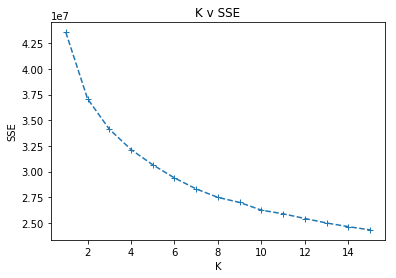

In [95]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(centers, scores, linestyle='--', marker='+');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('K v SSE');

In [96]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters = 14)
model_14_clusters = kmeans.fit(pca_azdias_final)
pred_azdias = model_14_clusters.predict(pca_azdias_final)

### Discussion 3.1: Apply Clustering to General Population

**Based on when the plot levels off I've decied to segment the population into 14 clusters.**

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [241]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
customers_df = clean_data(customers)

In [242]:
customers_df.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_HOUSEHOLD,CAMEO_INTL_2015_LIFESTAGE
0,4,1,5,1,5,1,2,2,1,1,...,0.0,5.0,5.0,1.0,2.0,1.0,50s,0,13,13
2,4,2,5,1,5,1,4,4,1,2,...,1.0,3.0,2.0,3.0,5.0,3.0,50s,0,34,34
3,4,1,5,1,5,2,1,2,0,2,...,0.0,3.0,4.0,1.0,3.0,1.0,40s,0,24,24
4,3,1,3,1,4,4,5,2,0,3,...,1.0,3.0,3.0,3.0,5.0,1.0,70s,0,41,41
5,3,1,5,1,5,1,2,3,1,3,...,1.0,5.0,5.0,3.0,7.0,5.0,50s,0,34,34


In [243]:
customers_df.isna().sum().sum()

71909

In [244]:
customers_df = customers_df.drop(['PRAEGENDE_JUGENDJAHRE_DECADE'], axis=1)

In [245]:
# replace NaN, same as other dataset

customers_clean = pd.DataFrame(replace_nan.transform(customers_df))
customers_clean.columns = customers_df.columns
customers_clean.index = customers_df.index

In [246]:
# scaler
customers_clean_scaled = azdias_scaler.transform(customers_clean)
customers_clean_scaled = pd.DataFrame(customers_clean_scaled, columns=list(customers_clean))

# pca
customers_pca = pca_azdias_30.transform(customers_clean_scaled)

In [247]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_pred = model_14_clusters.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [248]:
portion_of_general = []
portion_of_customers = []

x = [i+1 for i in range(14)]
for i in range(14):
    portion_of_general.append((pred_azdias == i).sum()/len(pred_azdias))
    portion_of_customers.append((customers_pred == i).sum()/len(customers_pred))
    
df_proportions = pd.DataFrame({'Clusters' : x, 'General Pop Proportion' :  portion_of_general, 'Customer Pop Proportion': portion_of_customers})


In [249]:
df_proportions.head()

,Clusters,General Pop Proportion,Customer Pop Proportion
0,1,0.088516,0.008365
1,2,0.102433,0.163315
2,3,0.072182,0.017992
3,4,0.074566,0.330025
4,5,0.076617,0.008244


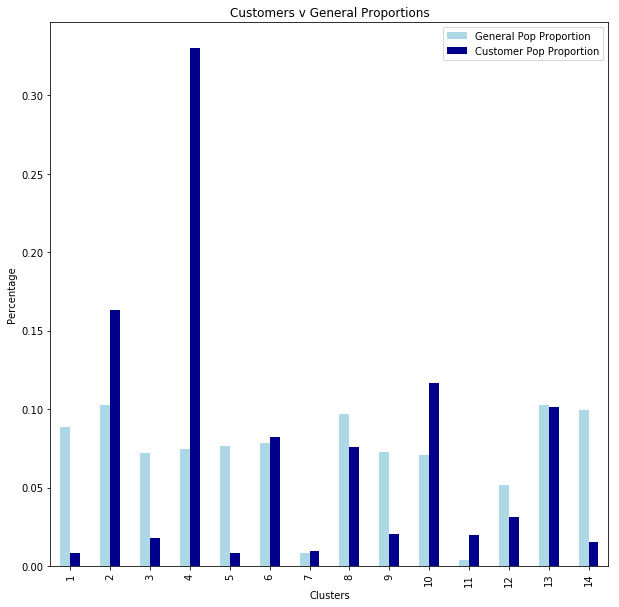

In [251]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

df_proportions.plot(x='Clusters',kind='bar', figsize=(10,10), title='Customers v General Proportions', color=('lightblue','darkblue'));
plt.ylabel('Percentage');

In [255]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
centroid_over = azdias_scaler.inverse_transform(pca_azdias_30.inverse_transform(model_14_clusters.cluster_centers_[4]))

In [256]:
centroid_over_data = pd.Series(data = centroid_over, index = customers_clean.columns)

In [257]:
centroid_over_data

ALTERSKATEGORIE_GROB                 1.773149
ANREDE_KZ                            0.954441
FINANZ_MINIMALIST                    1.885102
FINANZ_SPARER                        4.374844
FINANZ_VORSORGER                     2.122534
FINANZ_ANLEGER                       3.586230
FINANZ_UNAUFFAELLIGER                3.811820
FINANZ_HAUSBAUER                     3.633677
GREEN_AVANTGARDE                     0.114443
HEALTH_TYP                           2.341423
RETOURTYP_BK_S                       2.786307
SEMIO_SOZ                            6.741719
SEMIO_FAM                            6.793974
SEMIO_REL                            6.406090
SEMIO_MAT                            5.096147
SEMIO_VERT                           6.065336
SEMIO_LUST                           2.869849
SEMIO_ERL                            2.071395
SEMIO_KULT                           6.938917
SEMIO_RAT                            4.150194
SEMIO_KRIT                           2.772669
SEMIO_DOM                         

In [258]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
centroid_under = azdias_scaler.inverse_transform(pca_azdias_30.inverse_transform(model_14_clusters.cluster_centers_[1]))

In [259]:
centroid_under_data = pd.Series(data = centroid_under, index = customers_clean.columns)

In [260]:
centroid_under_data

ALTERSKATEGORIE_GROB                 3.300248
ANREDE_KZ                            1.100757
FINANZ_MINIMALIST                    4.445710
FINANZ_SPARER                        1.854713
FINANZ_VORSORGER                     4.089290
FINANZ_ANLEGER                       2.340456
FINANZ_UNAUFFAELLIGER                1.967109
FINANZ_HAUSBAUER                     2.079946
GREEN_AVANTGARDE                     0.069729
HEALTH_TYP                           2.388099
RETOURTYP_BK_S                       3.686716
SEMIO_SOZ                            4.634248
SEMIO_FAM                            4.645331
SEMIO_REL                            3.642490
SEMIO_MAT                            3.488196
SEMIO_VERT                           5.823426
SEMIO_LUST                           4.599354
SEMIO_ERL                            4.364946
SEMIO_KULT                           4.818701
SEMIO_RAT                            2.649323
SEMIO_KRIT                           3.686107
SEMIO_DOM                         

### Discussion 3.3: Compare Customer Data to Demographics Data
**Based on our charts we can see that centroid 4 is over represented along with 2 and 10. While centroid 1 is underrepresented by a wide margin along with 3, 5, 9, and 14.**


**Segments of the population that are relatively popular with the mail-order company are those who are less than 30 years old according to ALTERSKATEGORIE_GROB - 1.773149, have a very high affinity towards events according to SEMIO_ERL - 2.071395, and part of a community of 60K - 100K inhabitants according to ORTSGR_KLS9 - 6.849137**


**Segments that were relatively unpopular with the company have to do with those who are between the age of 46 and 60 according to ALTERSKATEGORIE_GROB - 3.300248, have an average affinity towards events according to SEMIO_ERL - 4.364946, and are part of a community with 5K to 10K inhabitants according to ORTSGR_KLS9 - 3.195835.**

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.